In [14]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format',lambda x: '{:.3f}'.format(x))

from subprocess import check_output


In [15]:
data = pd.read_csv('vlagunr-Phyto.csv')


In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(data,data['PhytoBiomassC'], test_size = 0.30, random_state=0)
X_train.shape,X_test.shape

((109, 19), (47, 19))

In [17]:
test = X_test
test.head(5)
train = X_train
train.head(5)

,Id,Date,PSU,O2,temp.,SRP,DOP,PP,NH4N,NO3N,DON,PN,TN/TP,Fe,SiO4Si,Windspeedinsitu,Depth,DIN to DIP,PhytoBiomassC
60,61,20080916,3.860,9.840,12.000,12.800,34.300,213.500,0.033,0.069,0.700,1.351,8.262,0.016,3.579,4.500,2.700,7.969,3.200
2,3,20080617,3.758,9.660,18.100,3.200,22.800,103.400,0.016,0.008,0.582,0.576,9.134,0.037,2.264,1.000,3.400,7.500,2.604
142,143,20090812,3.100,8.490,19.800,8.900,9.300,222.800,0.021,0.038,0.562,1.103,7.154,0.016,2.814,6.000,2.200,6.629,2.707
43,44,20080819,4.420,9.050,18.900,5.400,20.600,155.200,0.035,0.033,0.548,0.606,6.744,0.032,1.106,3.000,3.450,12.593,2.216
66,67,20080916,3.960,9.680,12.600,8.200,36.300,118.500,0.044,0.035,0.555,0.815,8.890,0.017,2.834,6.500,3.500,9.634,2.297


In [18]:
print("The train data size before dropping Id feature is: {}".format(train.shape))
print("The test data size before dropping Id feature is: {}".format(test.shape))

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis =1, inplace=True)
test.drop("Id", axis =1, inplace=True)

print("The train data size after dropping Id feature is: {}".format(train.shape))
print("The test data size after dropping Id feature is: {}".format(test.shape))


The train data size before dropping Id feature is: (109, 19)
The test data size before dropping Id feature is: (47, 19)
The train data size after dropping Id feature is: (109, 18)
The test data size after dropping Id feature is: (47, 18)



 mu = 2.17 and sigma = 0.93



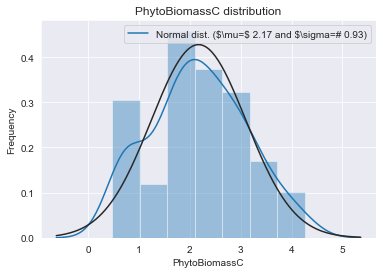

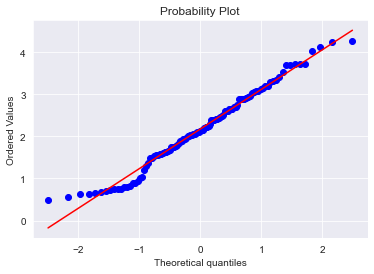

In [19]:
sns.distplot(train['PhytoBiomassC'], fit=norm)

(mu,sigma) = norm.fit(train['PhytoBiomassC'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=# {:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('PhytoBiomassC distribution')

fig = plt.figure()
res = stats.probplot(train['PhytoBiomassC'], plot=plt)
plt.show()


 mu = 1.11 and sigma = 0.32



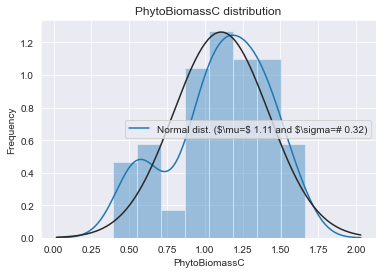

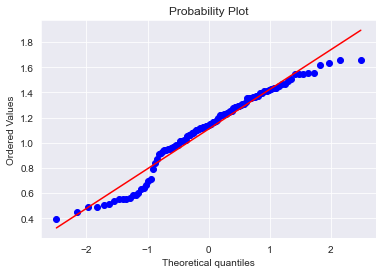

In [20]:
train['PhytoBiomassC'] = np.log1p(train['PhytoBiomassC'])

sns.distplot(train['PhytoBiomassC'], fit=norm);

(mu,sigma) = norm.fit(train['PhytoBiomassC'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=# {:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('PhytoBiomassC distribution')

fig = plt.figure()
res = stats.probplot(train['PhytoBiomassC'], plot=plt)
plt.show()

In [21]:
y_train = train.PhytoBiomassC.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['PhytoBiomassC'], axis=1, inplace=True)
print("all_data size is: {}".format(all_data.shape))

all_data size is: (156, 17)


<AxesSubplot:>

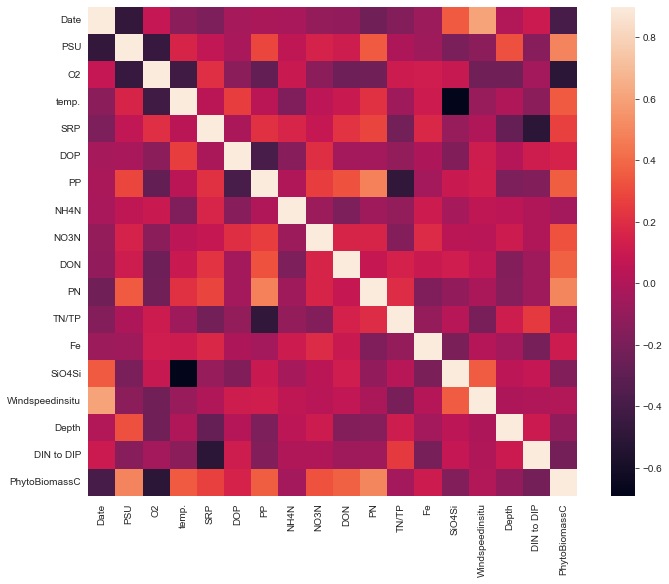

In [22]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [23]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features:/n")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

skewness = skewness[abs(skewness)> 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    # all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)


Skew in numerical features:/n
There are 17 skewed numerical features to Box Cox transform


In [24]:
ntrain = train.shape[0]
ntest = test.shape[0]

train = all_data[:ntrain]
test = all_data[ntrain:]

In [25]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [26]:
n_folds = 5


def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [27]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.6, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.6, l1_ratio=.9, random_state=3))

# Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [28]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='sqrt',min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)

In [29]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,learning_rate=0.05, max_depth=3, min_child_weight= 1.7817, n_estimators = 2200, reg_alpha = 0.4640, reg_lambda=0.8571,subsample=0.5213, silent=1, random_state =7, nthread = -1)

In [30]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin = 55, bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

In [31]:
score = rmsle_cv(lasso)
print('\nLasso score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))


Lasso score: 0.3136 (0.0562)



In [32]:
score = rmsle_cv(ENet)
print('ElasticNet score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

ElasticNet score: 0.3136 (0.0562)



In [33]:
score = rmsle_cv(KRR)
print('Kernel Ridge score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Kernel Ridge score: 0.2164 (0.0324)



In [35]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.2304 (0.0294)



In [36]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[16:59:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

In [37]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as seaborn
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
from subprocess import check_output

In [38]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)
        return self

    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [39]:
averaged_models = AveragingModels(models=(model_xgb, model_xgb, KRR, lasso))  
score = rmsle_cv(averaged_models)
print('Averaged base models score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

[16:59:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

In [40]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X,y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model = clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds, shuffle = True, random_state =156)

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models))) 
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X,y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
        
        self.meta_model.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) 
            for base_models in self.base_models_])
        return self.meta_model.predict(meta_features)

In [41]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_xgb, GBoost, lasso), meta_model = KRR)

score = rmsle_cv(stacked_averaged_models)
print('Stacking Averaged models score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

[16:59:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

In [42]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [43]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

[17:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:01:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:01:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

In [44]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[17:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.1077649134486914


In [45]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.021662325869775838


In [46]:
print('RMSLE score on train data: ')
print(rmsle(y_train,stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data: 
0.10211254253131855


In [47]:
ensemble = stacked_pred*0.7 + xgb_pred*0.15 + lgb_pred*0.15

In [48]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['PhytoBiomassC'] = ensemble
sub.to_csv('submission.csv', index=False)